In [1]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import cv2

In [2]:
def crop_wrap_letter(img, bounding_box):
    src=bounding_box
    maxWidth=224
    maxHeight=224
    input_pts = np.float32(src)
    # y comes first in the matrix
    output_pts = np.float32([[0, 0],
                            [maxHeight - 1, 0],
                            [maxHeight - 1, maxWidth - 1],
                            [0, maxWidth - 1]])
    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    out = cv2.warpPerspective(img,
                          M,
                          (maxWidth, maxHeight),
                          flags=cv2.INTER_LINEAR)
    return out

In [3]:
def crop_letter(img, bounding_box):
    bb=bounding_box
    maxWidth=224
    maxHeight=224
    
    x=int(min(bb[0,:]))
    y=int(min(bb[1,:]))
    width=int(max(bb[0,:])-min(bb[0,:]))
    height=int(max(bb[1,:])-min(bb[1,:]))
    
    img=img[y:y+height,x:x+width,:]
    return cv2.resize(img, (maxWidth, maxHeight))
    return out

In [4]:
def crop_wrap_image(img, charBB, fonts, label_encoder=None, wrap=True):
    for i in range(fonts.shape[0]):
        
        if wrap:
            bounding_box = np.dstack(charBB[:,:,i])[0]  # pairs of x,y
            crop = crop_wrap_letter(img, bounding_box)
        else:
            bounding_box = charBB[:,:,i]
            crop = crop_letter(img, bounding_box)
        crop = crop.reshape((1,224,224,3))  # Identify as 1 batch of image
        if not label_encoder:
            yield crop
        else:
            yield crop, np.array([label_encoder.transform([fonts[i]])])

In [5]:
def crop_wrap_data(db, im_names, label_encoder=None, wrap=True):
    for im in im_names:
        img = db['data'][im][:]
        fonts = db['data'][im].attrs['font']
        txt = db['data'][im].attrs['txt']
        charBB = db['data'][im].attrs['charBB']
        wordBB = db['data'][im].attrs['wordBB']
        
        yield from crop_wrap_image(img, charBB, fonts, label_encoder, wrap=wrap)

In [6]:
def data_generator(*args, **kwargs):
    while True:
        yield from crop_wrap_data(*args, **kwargs)

In [7]:
def font_label_data(db, im_names, label_encoder=None):
    for im in im_names:
        font = db['data'][im].attrs['font']
        
        for f in font:
            if not label_encoder:
                yield f
            else:
                label_encoder.transform([f])

In [8]:
def load_db():
    db = h5py.File('SynthText.h5', 'r')
    im_names = list(db['data'].keys())
    return db, im_names

In [9]:
def data_size(db, im_names):
    size = 0
    for im in im_names:
        font = db['data'][im].attrs['font']
        size += len(font)
    return size

In [10]:
db, im_names = load_db()

In [11]:
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(list(font_label_data(db, im_names)))
label_encoder.classes_, len(label_encoder.classes_)

(array([b'Alex Brush', b'Michroma', b'Open Sans', b'Raleway', b'Roboto',
        b'Russo One', b'Ubuntu Mono'], dtype='|S11'),
 7)

In [12]:
data = crop_wrap_data(db, im_names, label_encoder=label_encoder, wrap=True)

In [13]:
index = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

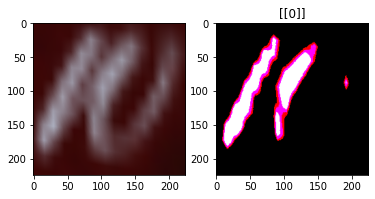

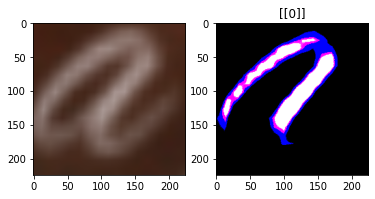

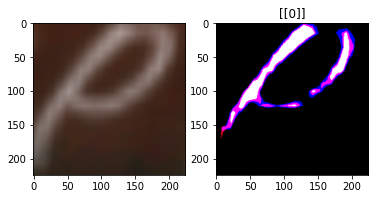

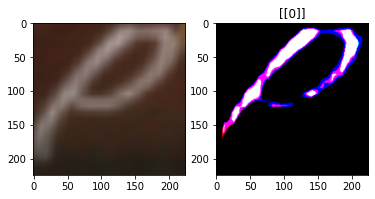

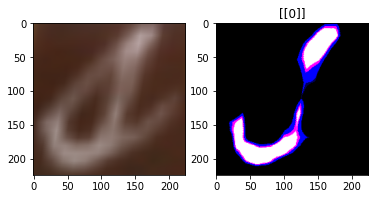

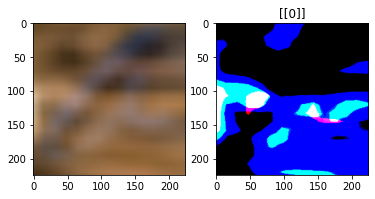

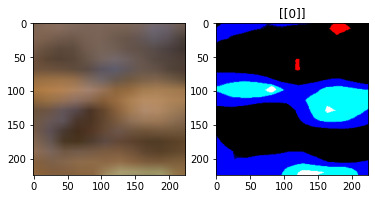

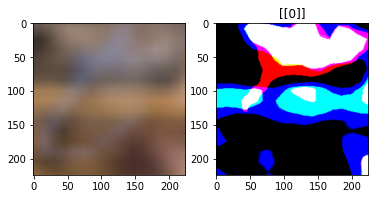

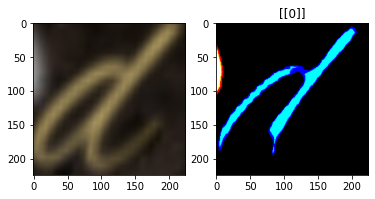

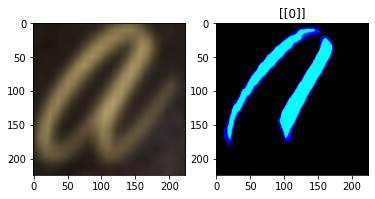

In [18]:
wanted_label = 0
c=0
for i, (ximg, label) in enumerate(data):
    if c==10:
        break
    if label==wanted_label:
        c+=1
    else:
        continue
    ximg = ximg.reshape((224,224,3))
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(ximg)
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.applications.resnet50.preprocess_input(ximg))
    plt.title(label)